In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np

## Read in Data

In [59]:
data_set = 'small'

In [60]:
# read in data and clean up extra headers
raw_cut_df = pd.read_csv(f'data/{data_set}/cut_iteration.csv', keep_default_na=False)
raw_cut_df = raw_cut_df[raw_cut_df['cut generation iteration'] != 'cut generation iteration']
raw_cut_df = raw_cut_df.astype({'disjunctive terms': 'int64',
                                'cut generation iteration': 'int64',
                                'root gap closed': 'float64'})

raw_restart_df = pd.read_csv(f'data/{data_set}/restart.csv')
raw_restart_df = raw_restart_df[raw_restart_df['restart'] != 'restart']
raw_restart_df = raw_restart_df.astype({'disjunctive terms': 'int64',
                                        'restart': 'int64',
                                        'additional root gap closed': 'float64',
                                        'iterations': 'int64'})

raw_termination_df = pd.read_csv(f'data/{data_set}/termination.csv')
raw_termination_df = raw_termination_df.astype(
    {'default cut generation iterations': 'Int64',
     'default and disjunctive cut generation iterations': 'Int64'}
)

instance_df = pd.read_csv(f'data/{data_set}/instance.csv')

## Summary Statistics

In [61]:
instance_df

,instance
0,gen-ip036
1,control30-3-2-3
2,mik-250-20-75-3
3,ic97_tension
4,markshare1
...,...
83,neos-3610040-iskar
84,prod2
85,aflow30a
86,glass4


In [62]:
raw_termination_df

,instance,disjunctive terms,termination mode,termination notes,default cut generation iterations,default and disjunctive cut generation iterations
0,mas76,4,restart optimality,NaN,20,9
1,control30-3-2-3,4,max number restarts,NaN,14,14
2,mas76,8,restart optimality,NaN,20,8
3,markshare1,4,max number restarts,NaN,10,10
4,ic97_tension,4,corrupted cuts,NaN,<NA>,<NA>
...,...,...,...,...,...,...
317,aflow30a,8,restart time limit,NaN,20,20
318,prod2,32,restart time limit,NaN,20,4
319,aflow30a,32,restart time limit,NaN,20,2
320,mik-250-20-75-4,16,restart time limit,NaN,20,10


### Termination Mode

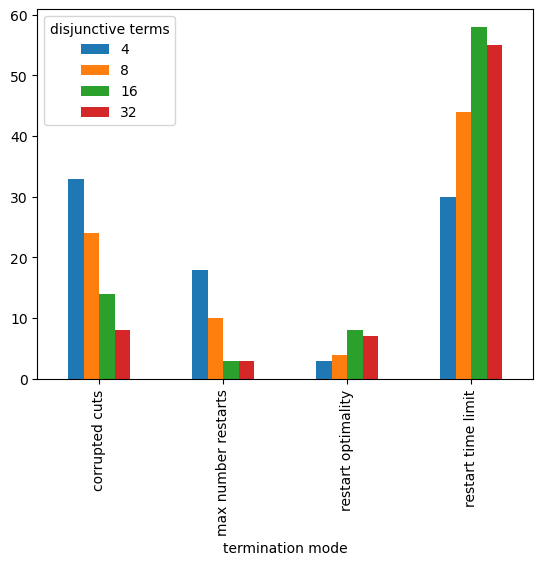

In [63]:
df = raw_termination_df.groupby(['disjunctive terms',
                                 'termination mode']).count()['instance'].reset_index()
df.pivot(index='termination mode', columns='disjunctive terms')['instance'].plot(kind='bar')
plt.show()

In [64]:
with pd.option_context('display.max_rows', 100, 'display.max_columns', 30):
    display(raw_termination_df.pivot(index='instance',
                                     columns='disjunctive terms')['termination mode'])

disjunctive terms,4,8,16,32
instance,,,,
22433,corrupted cuts,corrupted cuts,restart optimality,restart optimality
23588,restart time limit,restart time limit,restart time limit,restart time limit
aflow30a,corrupted cuts,restart time limit,restart time limit,restart time limit
assign1-5-8,restart time limit,restart time limit,restart time limit,restart time limit
b-ball,max number restarts,max number restarts,restart time limit,restart time limit
beavma,corrupted cuts,corrupted cuts,corrupted cuts,corrupted cuts
bienst1,restart time limit,restart time limit,restart time limit,NaN
bienst2,restart time limit,restart time limit,restart time limit,NaN
blend2,corrupted cuts,corrupted cuts,corrupted cuts,corrupted cuts


### Number of Restarts

array([[<AxesSubplot: title={'center': '4'}>],
       [<AxesSubplot: title={'center': '8'}>],
       [<AxesSubplot: title={'center': '16'}>],
       [<AxesSubplot: title={'center': '32'}>]], dtype=object)

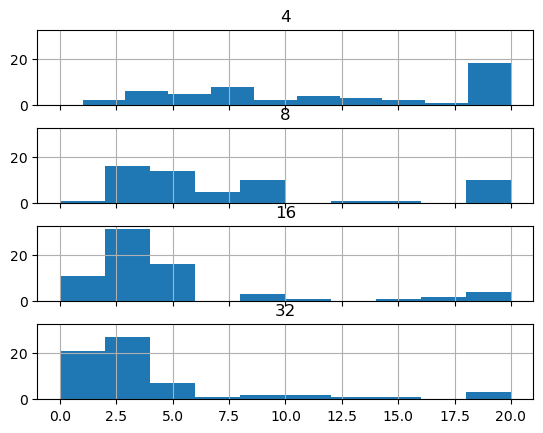

In [65]:
df = raw_restart_df.groupby(['instance', 'disjunctive terms']).max()['restart'].reset_index()
df = df.pivot(index='instance', columns='disjunctive terms')['restart']
df.hist(sharex=True, sharey=True, layout=(len(df.columns), 1))

In [66]:
df

disjunctive terms,4,8,16,32
instance,,,,
22433,NaN,NaN,0.0,0.0
23588,4.0,2.0,1.0,2.0
aflow30a,NaN,3.0,2.0,2.0
assign1-5-8,6.0,3.0,2.0,2.0
b-ball,20.0,20.0,8.0,5.0
...,...,...,...,...
supportcase16,NaN,NaN,0.0,0.0
supportcase20,NaN,2.0,2.0,1.0
supportcase26,20.0,12.0,5.0,5.0


## Clean Restart and Cut Iteration Data

In [33]:
raw_cut_df.loc[raw_cut_df['root gap closed'] > 1.01]

,instance,cuts,disjunctive terms,cut generation iteration,root gap closed
52,mas76,disjunctive only,4,3,1.311569
53,mas76,disjunctive only,4,4,1.325859
54,mas76,disjunctive only,4,5,1.340062
55,mas76,disjunctive only,4,6,1.452004
56,mas76,disjunctive only,4,7,1.625555
...,...,...,...,...,...
29195,mas74,disjunctive only,32,46,1.436254
29196,mas74,disjunctive only,32,47,1.436254
29197,mas74,disjunctive only,32,48,1.436254
29198,mas74,disjunctive only,32,49,1.436254


In [34]:
# check to make sure no mistakes made in generating cuts via unreasonable root gaps
bad_runs = raw_cut_df.loc[raw_cut_df['root gap closed'] > 1.01, ['instance', 'cuts', 'disjunctive terms']].drop_duplicates()
bad_runs

,instance,cuts,disjunctive terms
52,mas76,disjunctive only,4
106,mas76,default and disjunctive,4
358,mas76,disjunctive only,8
1555,mas76,disjunctive only,16
1606,mas76,default and disjunctive,16
2014,mas76,disjunctive only,32
2058,mas76,default and disjunctive,32
3253,gr4x6,default and disjunctive,4
4255,gr4x6,disjunctive only,8
4302,gr4x6,default and disjunctive,8


In [35]:
# remove unreasonable runs from raw_cut_df
merge = pd.merge(raw_cut_df, bad_runs, on=['instance', 'cuts', 'disjunctive terms'],
                 indicator=True, how='outer')
raw_cut_df = merge[merge['_merge'] == 'left_only'].drop('_merge', axis=1)

In [36]:
# remove unreasonable runs from raw_restart_df
merge = pd.merge(raw_restart_df, bad_runs[bad_runs['cuts'] == 'disjunctive only'],
                 on=['instance', 'disjunctive terms'], indicator=True, how='outer')
raw_restart_df = merge[merge['_merge'] == 'left_only'].drop('_merge', axis=1)

## Plot Cut Generation Progress at Last Iteration

In [108]:
tdf = raw_termination_df[~pd.isna(raw_termination_df['default cut generation iterations'])]
tdf.columns = list(tdf.columns[:-2]) + ['default', 'default and disjunctive']
tdf

,instance,disjunctive terms,termination mode,termination notes,default,default and disjunctive
0,mas76,4,restart optimality,NaN,20,9
1,control30-3-2-3,4,max number restarts,NaN,14,14
2,mas76,8,restart optimality,NaN,20,8
3,markshare1,4,max number restarts,NaN,10,10
5,control30-3-2-3,8,max number restarts,NaN,14,14
...,...,...,...,...,...,...
317,aflow30a,8,restart time limit,NaN,20,20
318,prod2,32,restart time limit,NaN,20,4
319,aflow30a,32,restart time limit,NaN,20,2
320,mik-250-20-75-4,16,restart time limit,NaN,20,10


In [109]:
tdf = pd.melt(tdf, id_vars=['instance', 'disjunctive terms'],
              value_vars=['default', 'default and disjunctive'],
              var_name='cuts', value_name='cut generation iteration')
tdf

,instance,disjunctive terms,cuts,cut generation iteration
0,mas76,4,default,20
1,control30-3-2-3,4,default,14
2,mas76,8,default,20
3,markshare1,4,default,10
4,control30-3-2-3,8,default,14
...,...,...,...,...
481,aflow30a,8,default and disjunctive,20
482,prod2,32,default and disjunctive,4
483,aflow30a,32,default and disjunctive,2
484,mik-250-20-75-4,16,default and disjunctive,10


In [ ]:
m = pd.merge(tdf, raw_cut_df,
             on=['instance', 'cuts', 'disjunctive terms', 'cut generation iteration'],
             how='inner')
m.loc[m['cuts'] == 'default and disjunctive', 'cuts'] = 'both'
m

In [ ]:
h = m.pivot(index='instance',
            columns=['disjunctive terms', 'cuts'])['cut generation iteration']
h.astype('Int64').hist(sharex=True, sharey=True, layout=(2, 4))

In [ ]:
m[(m['cuts'] == 'both') & (m['additional root gap closed'] > .001)].shape

## Plot Gap Closed at Each Cut Generation Iteration

In [37]:
# group dual bound progress at root by cuts applied and disjunctive terms
cut_df = dict(tuple(raw_cut_df.groupby(['cuts', 'disjunctive terms'])))
cuts = list({k[0] for k in cut_df})
disjunctive_term_list = list({k[1] for k in cut_df})

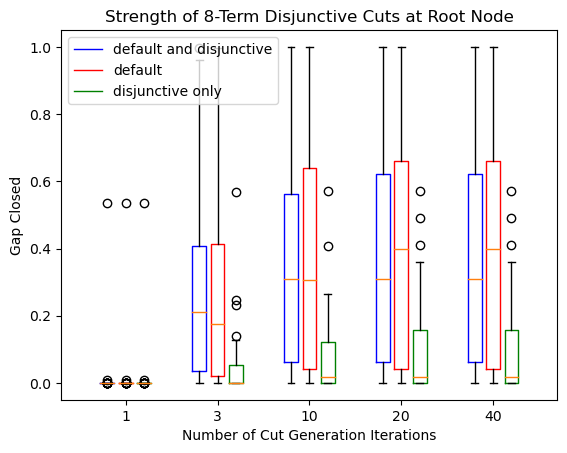

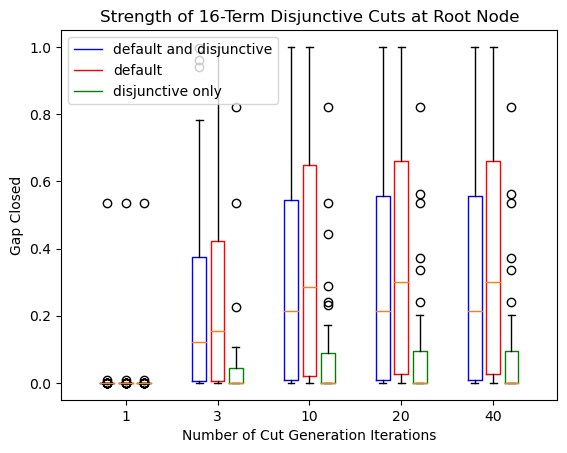

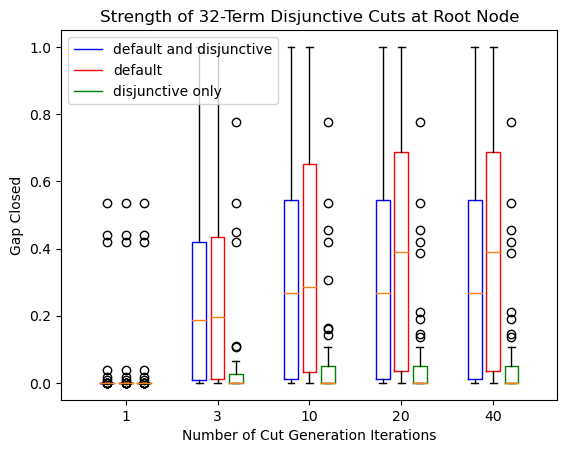

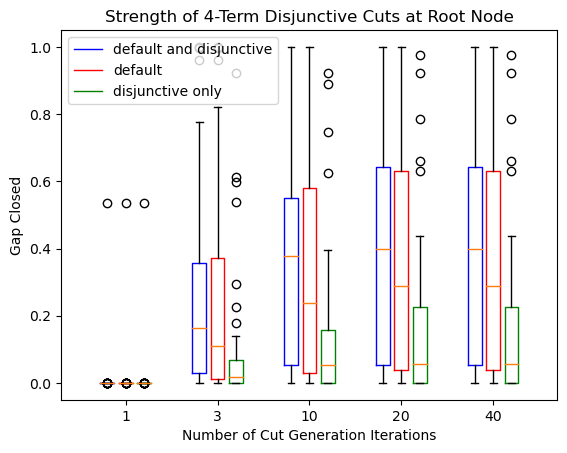

In [38]:
# which cut generation iterations to plot
iterations = [1, 3, 10, 20, 40]

# parameters for generating box plots
shift = .2
colors = ['b', 'r', 'g']  # must have same length as cuts
bp = {}

# make one plot for each number of disjunctive terms used
for disjunctive_terms in disjunctive_term_list:
    fig, ax = plt.subplots()
    
    # make a collection of box plots for each set of cuts used, plotting selected iterations
    for i, cut in enumerate(cuts):
        
        # get the dual bound progress for this combo of disjunctive term and type of cuts
        df = cut_df[cut, disjunctive_terms]
        
        # filter down to iterations of interest
        df = df[df['cut generation iteration'].isin(iterations)]
        
        # make one box plot for each cut generation iteration of interest
        gb = dict(tuple(df.groupby(['cut generation iteration'])['root gap closed']))
        bp[cut] = ax.boxplot(gb.values(), positions=np.arange(len(iterations))+(i - 1)*shift,
                             boxprops=dict(color=colors[i]), widths=.15)

    # set plot attributes
    ax.legend([b["boxes"][0] for b in bp.values()], bp.keys(), loc='upper left')
    ax.set_xticks(np.arange(len(iterations)))
    ax.set_xticklabels(iterations)
    ax.set(
        title=f'Strength of {disjunctive_terms}-Term Disjunctive Cuts at Root Node',
        xlabel='Number of Cut Generation Iterations',
        ylabel='Gap Closed',
        ylim=(-.05,1.05)
    )

    plt.show()

## Plot Gap Closed By Disjunctive Cuts after Each Restart

In [39]:
raw_restart_df

,instance,disjunctive terms,restart,additional root gap closed,iterations,cuts
3,control30-3-2-3,4,0,-1.000001,1,NaN
4,control30-3-2-3,4,1,0.000000,1,NaN
5,control30-3-2-3,4,2,0.000000,1,NaN
6,control30-3-2-3,4,3,0.000000,1,NaN
7,control30-3-2-3,4,4,0.000000,1,NaN
...,...,...,...,...,...,...
1863,mik-250-20-75-4,16,4,0.033902,20,NaN
1864,mik-250-20-75-4,32,0,-6.593554,1,NaN
1865,mik-250-20-75-4,32,1,0.073204,20,NaN
1866,mik-250-20-75-4,32,2,0.032355,20,NaN


In [40]:
# filter out restarts that occur less than a certain number of times
min_restarts = 10
count = raw_restart_df['restart'].value_counts()
raw_restart_df = raw_restart_df[raw_restart_df['restart'].isin(count.index[count.gt(min_restarts)])]

In [41]:
# group dataframe by number of disjunctive terms
restart_df = dict(tuple(raw_restart_df.groupby('disjunctive terms')[['restart', 'additional root gap closed']]))

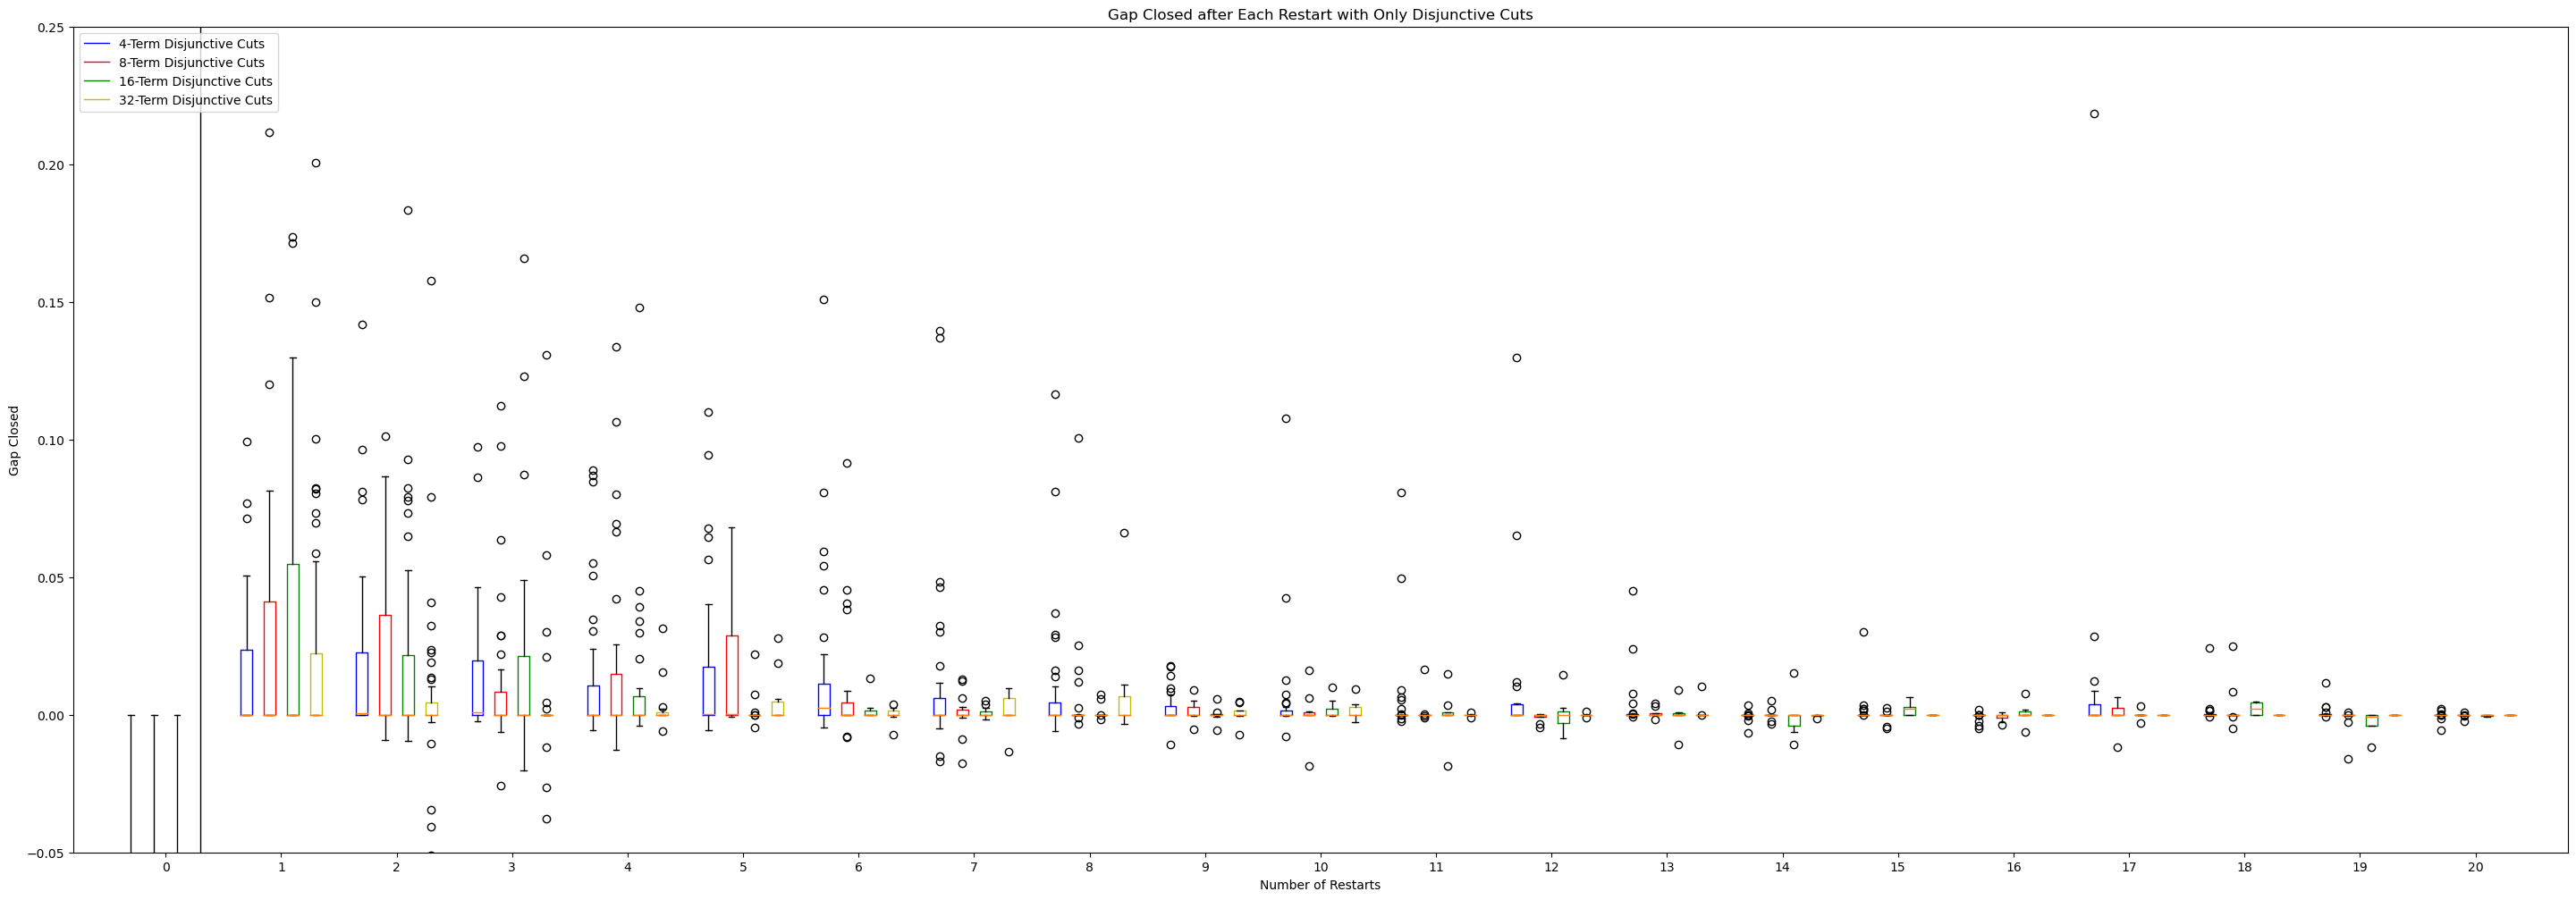

In [43]:
# make one plot for each number of disjunctive terms used
fig, ax = plt.subplots()

# parameters for generating box plots
shift = .2
colors = ['b', 'r', 'g', 'y']
assert len(colors) == len(restart_df), "colors must have same length as disjunctive term list"
bp = {}
ticks = np.sort(raw_restart_df['restart'].unique())

# for each number of disjunctive terms plot progress of each subsequent restart as box plot
for i, (disjunctive_terms, df) in enumerate(restart_df.items()):
    
    # for each number of disjunctive terms group data frame by restart
    gb = dict(tuple(df.groupby(['restart'])['additional root gap closed']))
    
    # plot each restart as a boxplot
    bp[disjunctive_terms] = ax.boxplot(gb.values(), positions=np.arange(len(gb))+(i - 1.5)*shift,
                                       boxprops=dict(color=colors[i]), widths=.1)

# set plot attributes
ax.legend([b["boxes"][0] for b in bp.values()], [f'{x}-Term Disjunctive Cuts' for x in bp],
          loc='upper left')
ax.set_xticks(np.arange(len(ticks)))
ax.set_xticklabels(ticks)
ax.set(
    title=f'Gap Closed after Each Restart with Only Disjunctive Cuts',
    xlabel='Number of Restarts',
    ylabel='Gap Closed',
    ylim=(-.05,.25),
)
fig.set_size_inches(36, 12)

plt.show()